### Assignment 13 Group 25
#### Prasanth Baskar (002890952) and Aswin Lakshmanan Sriram (002877313)

<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 10 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 21 March 2024</div>

# Metropolis Lab

Last lecture we studied the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) and used it to model some data we generated. 

We looked at the histogram of the data, decided to model it with a gaussian pdf, then used the Metropolis algorithm to "*predict*" the value of $\mu$. 

Then, we also used the algorithm to help us classify samples based on arbitrary binary-labeled data points on the $x,y$ plane.

So what we're going to do today is to put you into your final project groups (or help you form them today) and ask you to do the same thing, but to predict/estimate the **standard deviation** instead of the **mean**!

We are also going to use the **log-likelihood** instead of the likelihood, becase with 1,000 points, when we multipply 1,000 numbers less than 1, we are going to severely underflow. So yes, the math is going to be a little bit more complicated than before.

Please understand the formulas and write the code by filling-in the ellipses (`...`)!

In [12]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Data generation

We generate 30,000 samples from a normal distribution with $\mu$ = 10, and $\sigma$= 3. 

But let's say we can only observe 1000 of them. 

>**Our goal**: Use Bayesian estimation to build a **model** from the 1000 observations, then use the model to reconstruct (a simulation of) 30,000 samples.

### Fill in the `...` below!

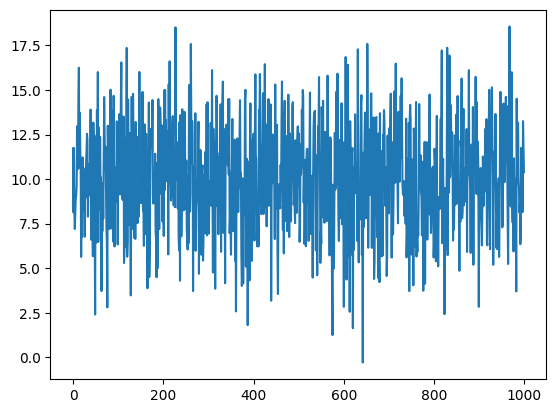

In [13]:
model=lambda mu, sig, t: np.random.normal(mu, sig, t)

# fill in the ...!
#Form a population of 30,000 individuals, with average=10 and sigma=3
population = model(10,3,30000)

#Assume we are only able to observe 1,000 of these individuals, sampled randomly amongst the 30000.
observations = population[np.random.randint(0,30000,1000)]
plt.plot(observations)

Let's start by plotting the histogram of these "*observed*" 1000 datapoints.

(10.001142129245508, 2.9851620147379743)

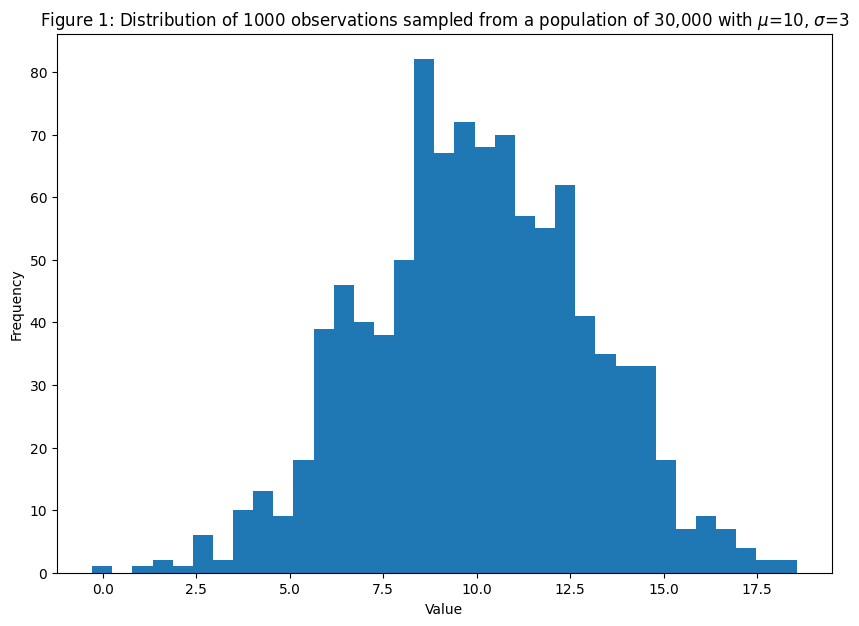

In [14]:
# Compute the histogram of these 1,000 observed individuals
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.hist( observations,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")

# fill in the ...!
#What is the inferred mu and sigma from these 1,000 observations?
mu_obs=observations.mean()
sig_obs=observations.std()
mu_obs, sig_obs

## Step 2: Which parameter to model?

Our model parameter vector $\theta$ is made up of two values: $[\mu,\sigma]$. Let's assume  $\mu$ is a constant, $\mu = \mu_{obs}$.

We don't know *how sure* we should be of the 1000-deduced value above `sig_obs` for the standard deviation.

<br />
<left>
<img src="ipynb.images/suspicious2.png " width=200 />
</left> 

We would like to find a distribution for $\sigma_{obs}$ using the 1000 observed samples. 

Some of you may say, "*but, professor, there is a formula for computing the standard deviation $\sigma$, and we used it above*".

***Everyone needs to know how to compute standard deviation from $n$ observations $d_i$ with mean $\mu$***:

$$\sigma=\sqrt{\frac{1}{n}\sum_i^n(d_i-\mu)^2}$$

Note however, that this only makes sense for a single-hump distribution, and that we are not trying to find a *single* value for $\sigma$, but rather, we are trying to compute a **distribution** of all possible values of $\sigma$.

## Step 3: Define the pdf for the prior and pdf for the likelihood

From the figure above, we can see that the data is **normally distributed**. The mean can be easily computed by taking the average of the values of the 1000 samples. By doing that, we get for example $\mu_{obs}=9.8$.

To predict the standard deviation, we need to model it with a pdf, let's pick a simple one: Why, the normal distribution $f$ of course!

\begin{equation} \sigma_{new} = f \sim N(\mu=\sigma_{current},\; \sigma'=1) \end{equation}

Note that $\sigma'$ is unrelated to $\sigma_{new}$ and $\sigma_{current}$. It simply specifies the standard deviation of our parameter space. It can be any value desired. It only affects the convergence time of the algorithm.

Note that we are modeling the standard deviation using the *mean* of a normal distribution. That's wierd! But when using the normal distribution, we always use its mean to model a parameter.

We don't have any preferences values that $\sigma_{new}$ and $\sigma_{current}$ can take, but they should be positive! Why? Intuitively, the standard deviation measures **dispersion**. Dispersion is a distance, and distances cannot be negative.

Mathematically, $\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$, and the square root of a number cannot be negative. We should strictly enforce this in the prior.

Our likelihood $f$ is the following pdf, for each data point $d_i$ in the data D:

\begin{equation} f(d_i\;|\; \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

## Step 4: Define when we accept or reject $\sigma_{new}$: 
Our Metropolis algorithm says that we accept a new guess $\sigma_{new}$ from the old position $\sigma_{current}$ if:

$\dfrac{\text{Likelihood}(D \;|\; \mu_{obs},\sigma_{new})\; * \; \text{prior}(\mu_{obs},\sigma_{new})}{\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{current})\;*\;\text{prior}(\mu_{obs},\sigma_{current})} \;\;>\;\; 1     \quad \quad \quad \quad \quad      (1)$

However, if this ratio is smaller or equal to 1, then we compare it to a uniformly generated random number in the closed set [0,1] (the amount by which our boyfriend/girlfriend's dinner is *better* than ours ;-).

If the ratio is larger than the random number, we accept $\sigma_{new}$, otherwise we reject it.


## Step 5: Acceptance condition derivation (using *log* likelihood):

The total likelihood for a set of observations $D$ is: $\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) = \prod_i^n f(d_i\;|\;\mu_{obs},\sigma_{new}) $

This is the product of all our data points. Just like if I asked you what is the likelihood I will draw *four* heads in a row if I flip a coin, you would say it's $\prod_i^n f$ with $f = 0.5$, so $0.5 * 0.5 * 0.5 * 0.5$.

In this notebook, we will **log** both the prior and the likelihood function. Why log? Simply because it helps with 
**numerical stability**, i.e. multiplying thousands of small values (probabilities, likelihoods, etc..) can cause an **underflow** in  system memory (like it did in our previous notebook where we had 0s for our total likelihood), and the **log** is a perfect solution because it transforms multiplications to **additions** and small positive numbers into not-so-small negative numbers.

Therefore our acceptance condition from equation $(1)$ above:
Accept $\sigma_{new}$ if:

$$\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) * \text{prior}(\mu_{obs},\sigma_{new})) > \\ \text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current}) *  \text{prior}(\mu_{obs},\sigma_{current}))$$

After taking the **log** of equation (1), since **log** is a [monotonic](https://en.wikipedia.org/wiki/Monotonic_function) function:

$$Log(\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) * \text{prior}(\mu_{obs},\sigma_{new}))) > \\ Log(\text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current}) *  \text{prior}(\mu_{obs},\sigma_{current})))$$

Also, since $Log(a * b) = Log(a) + Log(b)$, our condition becomes:

$$Log(\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new})) + Log(\text{prior}(\mu_{obs},\sigma_{new})) - (Log(\text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current})) + Log(prior(\mu_{obs},\sigma_{current})))\;>\;0$$

By plugging in $\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) = \prod_i^n f(d_i\;|\;\mu_{obs},\sigma_{new}) $, our condition becomes:

 $$\sum_i^nLog(f(d_i\;|\;\mu_{obs},\sigma_{new})) + Log(\text{prior}(\mu_{obs},\sigma_{new})) - \sum_i^nLog(f(d_i\;|\;\mu_{obs},\sigma_{current}))-Log(\text{prior}(\mu_{obs},\sigma_{current}))>0$$
 
 $\quad$
 
 
By plugging in \begin{equation} f(d_i\;|\; \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

Our condition becomes: 
  
$$\sum_i^n -Log(\sigma_{new}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{new}^2} \;\;+\;\; Log(prior(\mu_{obs},\sigma_{new})) \quad > \\
\quad \sum_i^n -Log(\sigma_{current}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{current}^2} \;\;+\;\; Log(prior(\mu_{obs},\sigma_{current})) \quad \quad  (2)$$

So (2) will be our acceptance condition:
- If true, we will always accept $\sigma_{new}$ as our next value in the chain
- If false, ***we will only accept it according to a probability equal to the ratio of the nominators*** (like in the lecture notebook).

So let's put this math into code. That's what data scientists *do*!

In [15]:
np.random.normal(1, 0.5)

0.42578742082755905

In [16]:
np.random.normal(1, 0.5, (1,))

array([1.74152031])

You will need to implement the code in the ellipses (`...`) bere below:

In [22]:
#The transition model defines how to move from sigma_current to sigma_new
#x[0] = mu, x[1] = sigma (new or current)
transition_model = lambda x: [x[0], np.random.normal(x[1], 0.5, (1,))]

# enforce sigma positive
def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <= 0):
        return 0
    
    # fill in the ...!
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x, data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow. Don't use it
def log_lik_normal(x, data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0], x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        # we are always right!
        return True
    else:
        # We'll say that our boyfriend/girlfriend is sometimes right, using a randon number generator
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new - x)))


# fill in the ...!
def metropolis_hastings(likelihood_computer, prior, transition_model, param_init, iterations, data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x, data)
        x_new_lik = likelihood_computer(x_new, data) 
        if acceptance_rule(x_lik,x_new_lik):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted ,dtype="object"), np.array(rejected , dtype="object")

See what a kind prof I am? I gave you *most* of the code! But you still need to fill-in the ellipses (...).

<br />
<center>
<img src="ipynb.images/spongebob-squarepants.png" width=400 />
</center>

## Step 6: Run the algorithm with initial parameters and collect accepted and rejected samples from 50,000 iterations

In [23]:
accepted, rejected = metropolis_hastings(manual_log_like_normal, prior, transition_model, [mu_obs,0.1], 50000, 
                                         observations, acceptance)

In [24]:
len(accepted)

8401

In [25]:
len(rejected)

41599

The algorithm accepted 8803 samples (which might be different on each new run).

The last 10 samples contain the following  values for $\sigma$:

In [26]:
accepted[-10:,1]

array([array([2.91654397]), array([3.16006563]), array([2.892529]),
       array([3.08746447]), array([3.11977063]), array([2.97647203]),
       array([3.13444724]), array([3.05098225]), array([3.01897705]),
       array([2.89017178])], dtype=object)

In [27]:
print(accepted.shape)

(8401, 2)


Let's plot accepted and rejected values:

(8401, 2)

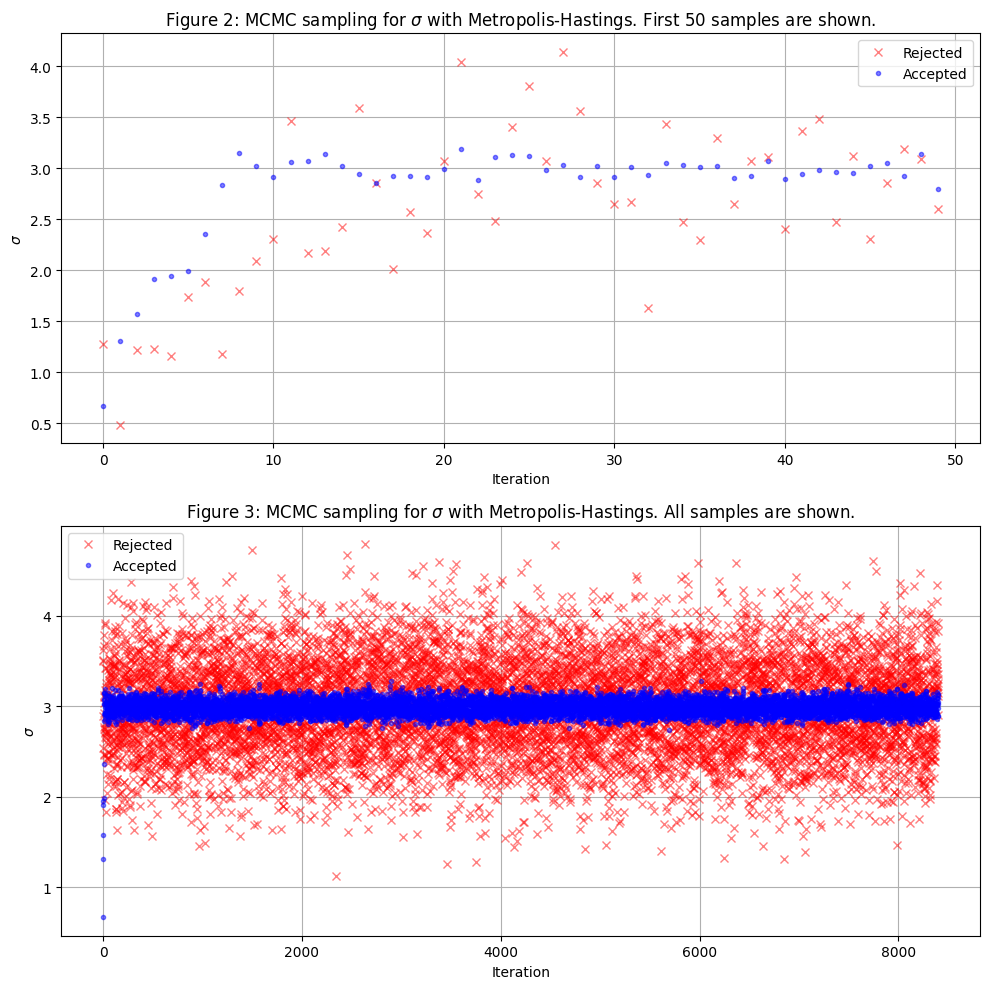

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

So, starting from an initial σ of 0.1, the algorithm converged pretty quickly to the expected value of 3.

### We consider the initial 25% of the values of $\sigma$ to be "burn-in", so we drop them.

In [29]:
len(accepted) / 4

2100.25

In [30]:
# fill-in the ...
accepted[-10:,1].mean()

array([3.0247424])

### Let's visualize the trace of  $\sigma$ and the histogram of the trace
(this will take a few minutes)..

In [31]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

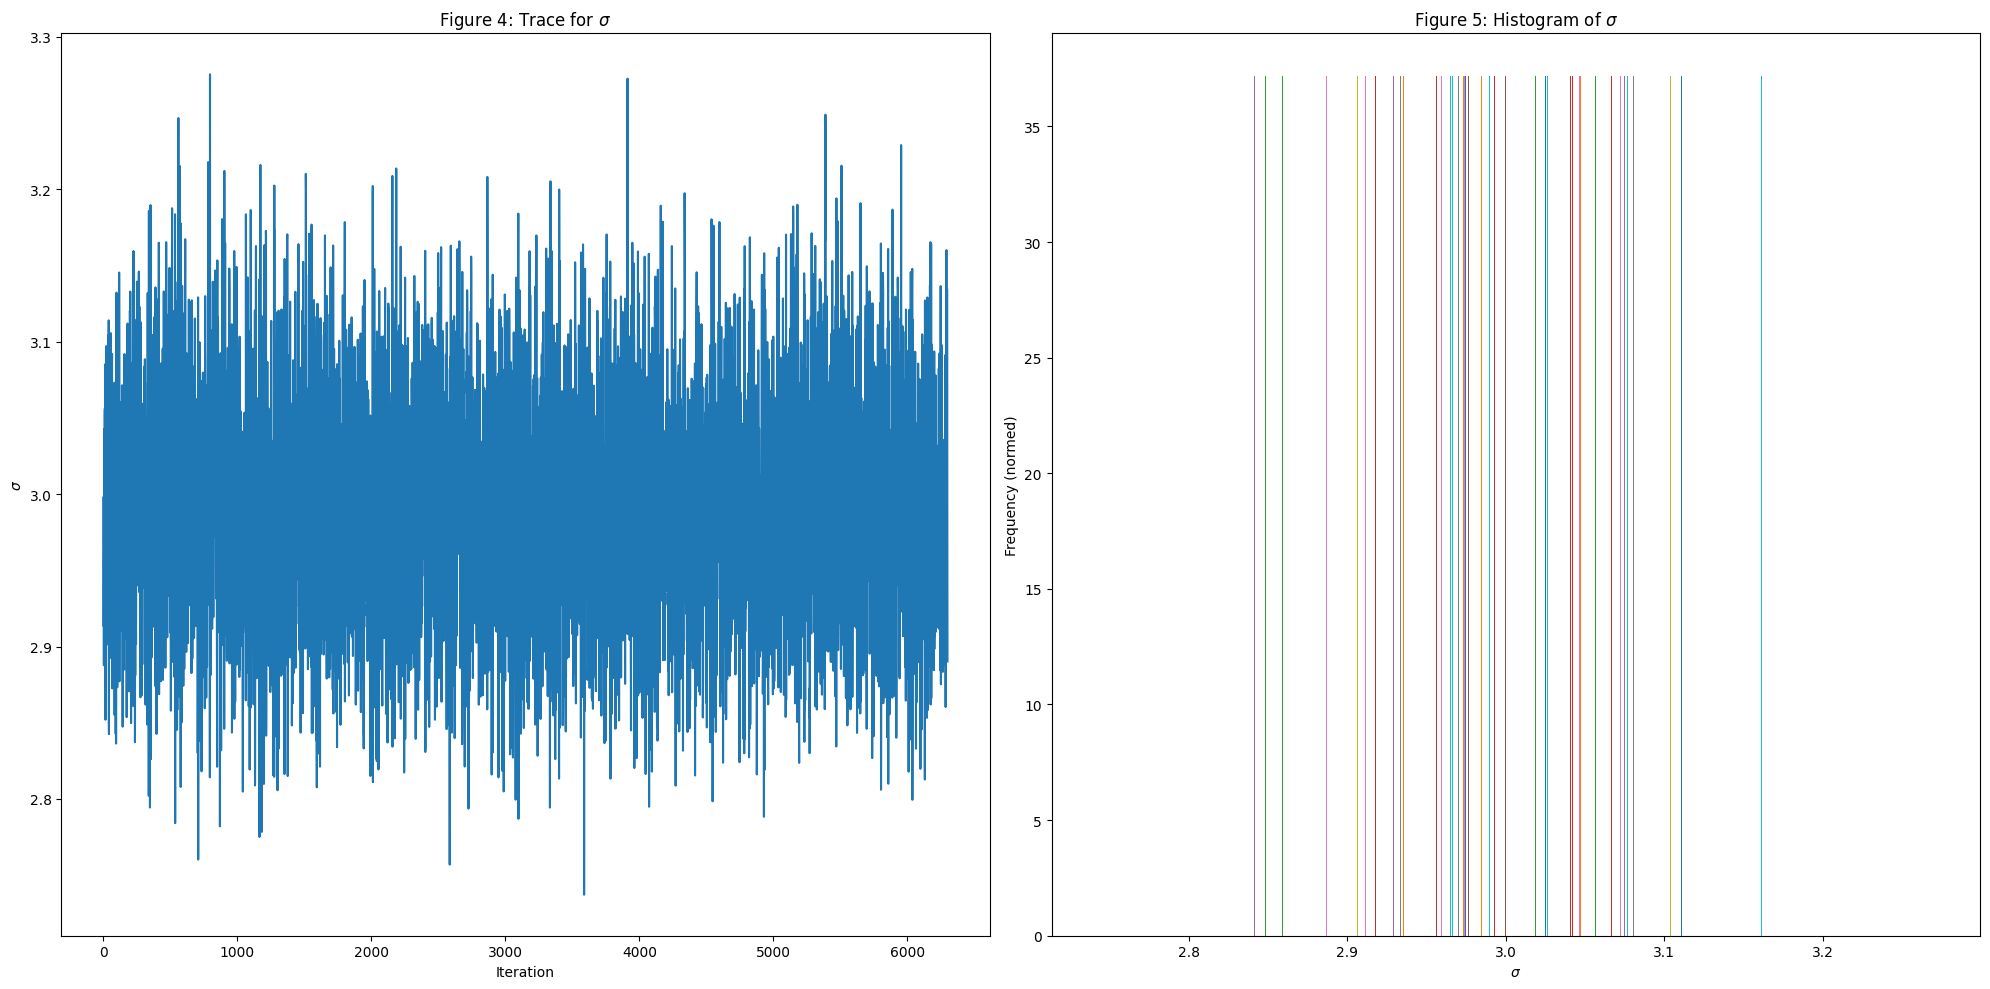

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()

#ax.grid("off")

### The most likely value for $\sigma$ is .... This is a bit more than the original value of 3.0. 

The difference is due to us observing only 3.33% of the original population (1,000 out of 30,000) 

# Prediction/Inference
First, we average the last 75% of accepted samples of σ, and we generate 30,000 random individuals from a normal distribution with μ=9.8 and σ=3.05 (the average of the last 75% of accepted samples) which is actually better than the most likely value of 3.1.

Then we compare against the original data of 30,000 individuals.

10.001142129244284 [2.9905494]


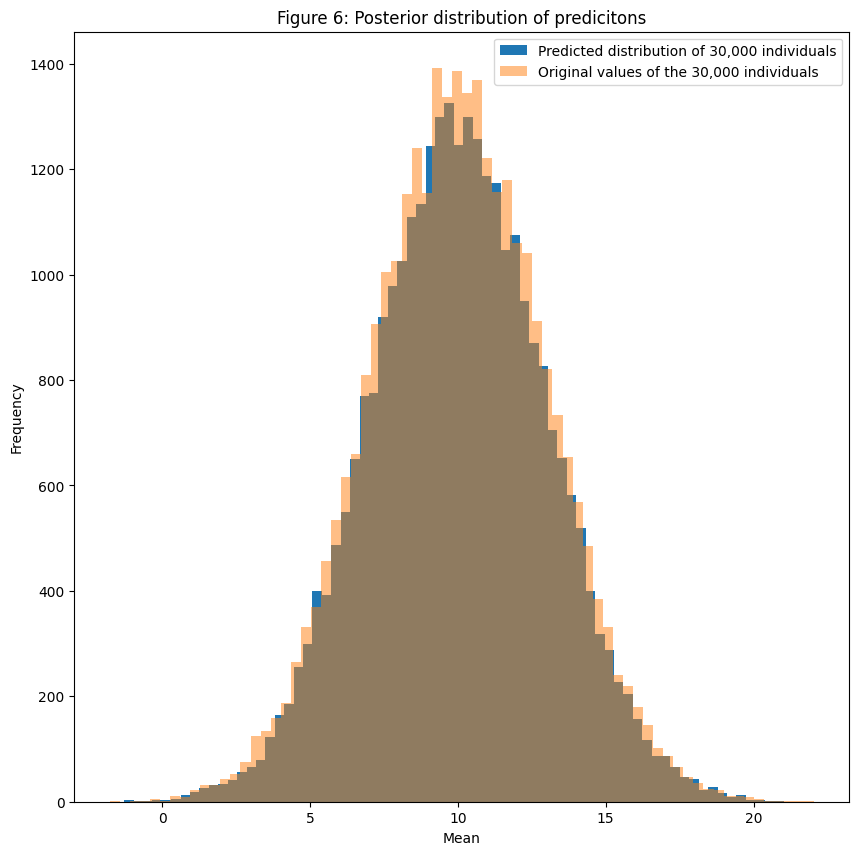

In [34]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()

Good fit? Our model, generated from a small 1,000 datapoint sample of 30,000 observations, succeeds in modelling all 30,000 observations.

# Conclusion

That is how computational statistics works. Assume distributions for your model parameters, and let computers run simulations without bias!

The Metropolis–Hastings algorithm generates a sequence of sample values in such a way that, as more and more sample values are produced, the distribution of values more closely approximates the desired distribution. 


Of course, if you *assumed* bias in your model shapes, then you may also get junk values. But actually we see that, most of the time*, our sims actually can *correct our initial mistakes* and give us not just most probably parameter values, but actual parameter pdfs that look *nothing like what we started with*.

>That is computers erasing our bias! :-)

The great thing about probabilistic programming is that you only need to write down the model and then run it. The simplest MCMC algorithm, [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), is simple. There is no need to compute evidence (denominator), or ensure constraining mathematical properties.